In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from datetime import datetime
from torch.utils.data import Dataset, DataLoader

In [5]:
df=pd.read_csv("/content/drive/MyDrive/5g_hack/synthetic_dataset_56_cells.csv")
newdf={}
# newdf['day']=[]
newdf['Time']=[]
newdf['cell_id']=[]
newdf['cell_type']=[]
newdf['load']=[]
# parsed_date = datetime.strptime(date_str, "%m/%d/%Y %H:%M")
for i in range(len(df)):
  # newdf['day'].append(datetime.strptime(df.iloc[i,0].split(' ')[0], "%m/%d/%Y").day)
  newdf['Time'].append(df.iloc[i,0])
  newdf['cell_id'].append(int(df.iloc[i,1].split("_")[1])+1)
  newdf['cell_type'].append(1 if df.iloc[i,2]=='Coverage Cell' else 2)
  newdf['load'].append(df.iloc[i,3])
newdf=pd.DataFrame(newdf)
print(newdf)
# print(newdf.iloc[:10.:])
# newdf=newdf.iloc[:118768,:]

        Time  cell_id  cell_type       load
0        729        2          1   7.861400
1        729        2          1   7.617041
2        727        2          1   7.933285
3        727        2          1   7.093256
4        725        2          1   7.371482
...      ...      ...        ...        ...
213915     1       57          2   8.392078
213916   371       57          2  17.278704
213917   372       57          2  17.165510
213918   395       57          2  17.258940
213919   395       57          2  17.463202

[213920 rows x 4 columns]


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
array_2d = newdf.iloc[:, :3].to_numpy()

In [ ]:
array_2d

NameError: name 'array_2d' is not defined

In [13]:
y=newdf.iloc[:,3].to_numpy()
print(y)

[ 7.86140011  7.61704146  7.93328496 ... 17.16550956 17.25894019
 17.46320192]


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
def train(net, lr, X, Y, epochs, batch_size=32, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    epochs: int
    batch_size: int, default=32
    verbose: bool, default=True
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    num_samples = X.shape[0]
    num_batches = (num_samples + batch_size - 1) // batch_size

    for epoch in range(epochs):
        running_loss = 0.0
        for i in range(num_batches):
            optimizer.zero_grad()
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, num_samples)
            batch_X = X[start_idx:end_idx]
            batch_Y = Y[start_idx:end_idx]
            outputs = net(batch_X)
            loss = criterion(outputs, batch_Y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {running_loss / num_batches:.6f}")


In [9]:
import matplotlib.pyplot as plt
def test(net, X, Y):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    criterion = nn.MSELoss()
    outputs = net(X)

    actual_values = Y[:20].detach().cpu().numpy()
    predicted_values = outputs[:20].detach().cpu().numpy()

    # Plotting the actual vs. predicted values
    plt.figure(figsize=(12, 6))
    plt.plot(actual_values, label='Actual Values', marker='o', linestyle='-')
    plt.plot(predicted_values, label='Predicted Values', marker='x', linestyle='--')

    # Adding labels and title
    plt.xlabel('Sample Index')
    plt.ylabel('Values')
    plt.title('Actual vs Predicted Values')
    plt.legend()
    plt.grid(True)
    plt.show()

    print("actual_values: ",Y[:20])
    print("outputs: ",outputs[:20])

    loss = criterion(outputs, Y)
    print(f"Test loss: {loss.item():.6f}")

In [10]:
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

In [11]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

In [14]:
y = y.reshape(-1, 1)

In [15]:
xrffa=torch.tensor(array_2d,dtype=torch.float32).to(device)
X_rff = create_rff_features(xrffa, 1000, 0.008)

In [16]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_rff, y, test_size=0.2, random_state=42)

In [ ]:
# print(y_train)


<ipython-input-17-1f7c45ea0d5f>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch_trainx=torch.tensor(x_train,dtype=torch.float32).to(device)


Epoch 0 loss: 31.651142


<ipython-input-17-1f7c45ea0d5f>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch_testx=torch.tensor(x_test,dtype=torch.float32).to(device)


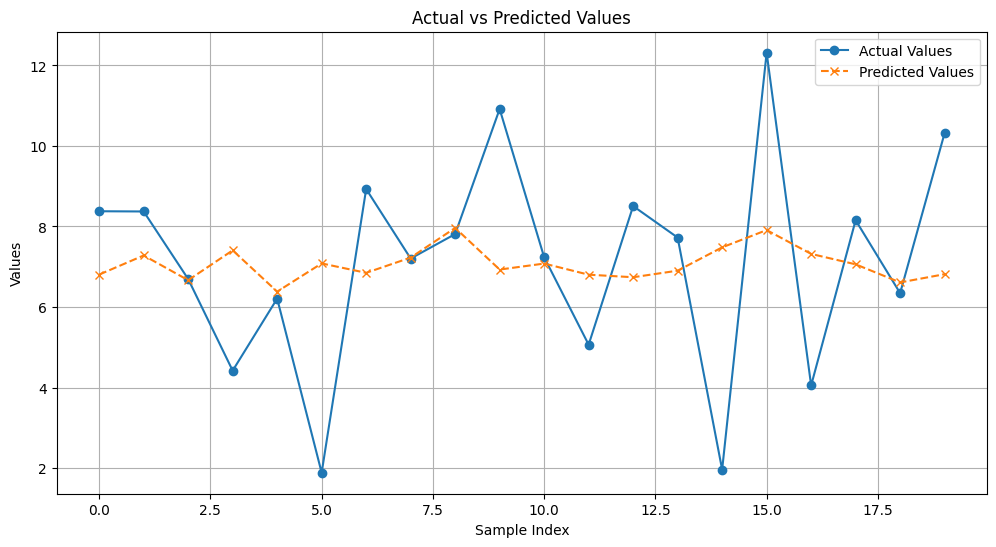

actual_values:  tensor([[ 8.3784],
        [ 8.3727],
        [ 6.6952],
        [ 4.4204],
        [ 6.2089],
        [ 1.8854],
        [ 8.9300],
        [ 7.2044],
        [ 7.8117],
        [10.9173],
        [ 7.2364],
        [ 5.0650],
        [ 8.5068],
        [ 7.7248],
        [ 1.9616],
        [12.3150],
        [ 4.0527],
        [ 8.1556],
        [ 6.3449],
        [10.3213]], device='cuda:0')
outputs:  tensor([[6.8053],
        [7.2806],
        [6.6662],
        [7.4073],
        [6.3826],
        [7.0830],
        [6.8491],
        [7.2276],
        [7.9647],
        [6.9303],
        [7.0791],
        [6.8031],
        [6.7397],
        [6.9027],
        [7.4815],
        [7.9109],
        [7.3190],
        [7.0602],
        [6.6107],
        [6.8155]], device='cuda:0', grad_fn=<SliceBackward0>)
Test loss: 14.985822


In [17]:
torch_trainx=torch.tensor(x_train,dtype=torch.float32).to(device)
torch_y=torch.tensor(y_train,dtype=torch.float32).to(device)
# X_rff = create_rff_features(torch_trainx, 10000, 0.008)
net = LinearModel(X_rff.shape[1], 1)
net.to(device)
train(net, 0.005, torch_trainx,torch_y, 100,100,True)
torch_testx=torch.tensor(x_test,dtype=torch.float32).to(device)
torch_y=torch.tensor(y_test,dtype=torch.float32).to(device)
#test(net,torch_testx,torch_y)

In [18]:
model_path = "/content/drive/MyDrive/5g_hack/trained_model.pth"  # Specify the file name

# Save the model's state dictionary
torch.save(net.state_dict(), model_path)

print("Model saved to", model_path)

Model saved to /content/drive/MyDrive/5g_hack/trained_model.pth


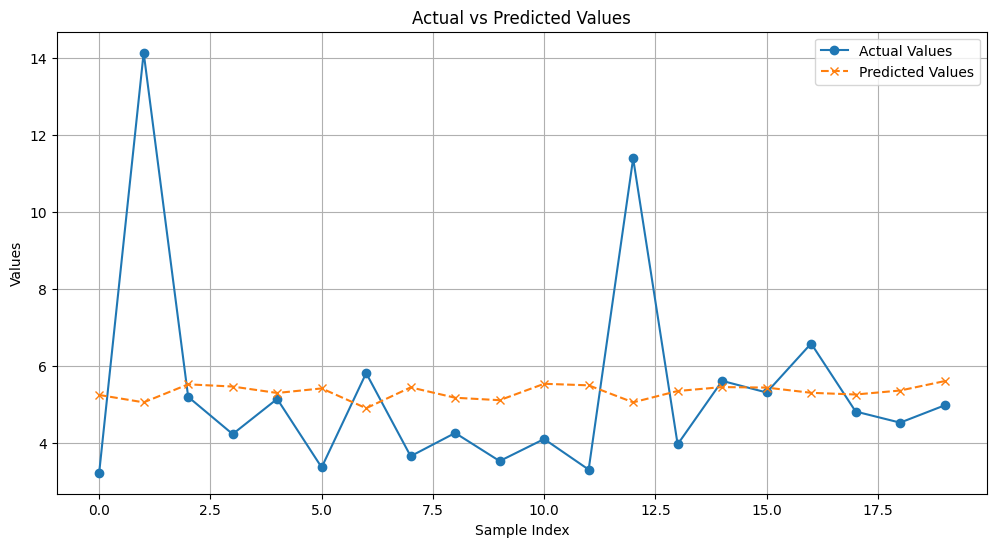

actual_values:  tensor([[ 3.2210],
        [14.1313],
        [ 5.1909],
        [ 4.2241],
        [ 5.1382],
        [ 3.3592],
        [ 5.8085],
        [ 3.6503],
        [ 4.2538],
        [ 3.5237],
        [ 4.0963],
        [ 3.3021],
        [11.3863],
        [ 3.9581],
        [ 5.6071],
        [ 5.3049],
        [ 6.5773],
        [ 4.8109],
        [ 4.5217],
        [ 4.9708]], device='cuda:0')
outputs:  tensor([[5.2409],
        [5.0488],
        [5.5169],
        [5.4595],
        [5.2928],
        [5.4109],
        [4.8969],
        [5.4378],
        [5.1686],
        [5.1051],
        [5.5313],
        [5.4911],
        [5.0493],
        [5.3437],
        [5.4456],
        [5.4325],
        [5.2970],
        [5.2529],
        [5.3562],
        [5.6005]], device='cuda:0', grad_fn=<SliceBackward0>)
Test loss: 6.292185


In [ ]:
test(net,torch_testx,torch_y)